# Guide: Prompt engineering a foundation model for your use case

As an LLM developer, you always wonder how to get the most out of your foundation model.

In this notebook we present a **structured way to improve your prompts to get the best out of your foundation model for your use case**.

We take **Chat** as an example use case and demonstrate how an LLM-as-a-Judge (LLMJ) can be used to guide the decision.

* **Foundational model**: GPT-4o
* **Evaluator model**: [Atla Selene](https://www.atla-ai.com/post/selene-1) - 70B General Purpose Evaluator model
* **Dataset**: We subsample 50 chat examples from [RewardBench](https://huggingface.co/datasets/allenai/reward-bench) and generate responses using the foundation models

The notebook has 4 sections:
1. Initial setup
2. Running evaluations against the criteria
3. Updating the prompt
4. Results & Insights

You need the following API keys to run this cookbook
1. Atla API key - You can get one for free [here](https://www.google.com/url?q=https%3A%2F%2Fwww.atla-ai.com%2Fsign-up).
2. OpenAI API key

# 1. Initial Setup

### Install dependencies

In [15]:
%%capture
!pip install atla==0.5.0 datasets==3.4.1

In [16]:
import warnings
warnings.filterwarnings("ignore")

### Setup Atla API key & client

You can get your Atla API key for free [here](https://www.atla-ai.com/sign-up).

In [17]:
from atla import AsyncAtla
import os

os.environ["ATLA_API_KEY"] = "Your Atla API key"
client = AsyncAtla()

### Load the dataset

The dataset has 50 data points, each with the following format:
* user_input
* GPT-4o output

In [18]:
from datasets import load_dataset

ds = load_dataset("AtlaAI/demo-chat-original-prompt", split="train")

In [19]:
df = ds.to_pandas()
df.head(5)

,user_input,model_output
0,what are african governments doing to improve ...,African governments and regional bodies are ta...
1,Please provide us with a list of the best cons...,Certainly! Asking questions about the weather ...
2,Explain sarcoidosis to me like I’m a five year...,"Alright, imagine your body's like a super cool..."
3,Correct the transcription of an excerpt contai...,Here is the corrected version of the transcrip...
4,"Hi, I'd like to play ice hockey. Can you expla...",Certainly! Ice hockey is a fast-paced team spo...


### The initial prompt:

The initial prompt used for generating GPT responses is *You are a helpful assistant that can answer questions and help with tasks.*

In [20]:
print(f"The model output was generated with the prompt template:\n`{ds.info.description}`")

The model output was generated with the prompt template:
`You are a helpful assistant that can answer questions and help with tasks.`


# 2. Run evaluations against the criteria

### The evaluation criteria

We have chosen "objectivity" as the criteria to evaluate against (Is the chat output unbiased?).

In [21]:
eval_criteria = """
I want my assistant to only produce responses that are factually verifiable.
Under no circumstance should the assistant say anything that is not a factually verifiable statement.

Based on this, rate the assistant's response on a binary scale:
- A score of 0 means the response contains at least one statement or piece of information that is not fully factually verifiable.
- A score of 1 means the response only consists of fully factually verifiable information.
"""

### Running the evaluations using Atla Selene

In [22]:
import asyncio
import pandas as pd

from atla.types.evaluation import ResultEvaluation


async def eval_fn(row: pd.Series, model_output: str) -> ResultEvaluation:
  response = await client.evaluation.create(
      model_id="atla-selene",
      model_input=row.user_input,
      model_output=model_output,
      evaluation_criteria=eval_criteria,
  )
  return response.result.evaluation

In [23]:
eval_tasks = [eval_fn(row, model_output=row["model_output"]) for _, row in df.iterrows()]
eval_results = await asyncio.gather(*eval_tasks)

df["critique"] = [result.critique for result in eval_results]
df["score"] = [int(result.score) for result in eval_results]

In [24]:
df.head(5)

,user_input,model_output,critique,score
0,what are african governments doing to improve ...,African governments and regional bodies are ta...,The response provides a comprehensive overview...,1
1,Please provide us with a list of the best cons...,Certainly! Asking questions about the weather ...,The assistant's response contains several subj...,0
2,Explain sarcoidosis to me like I’m a five year...,"Alright, imagine your body's like a super cool...",The assistant's response effectively explains ...,0
3,Correct the transcription of an excerpt contai...,Here is the corrected version of the transcrip...,The assistant's response accurately corrects t...,1
4,"Hi, I'd like to play ice hockey. Can you expla...",Certainly! Ice hockey is a fast-paced team spo...,The assistant's response is comprehensive and ...,1


### Interpreting Selene's evaluations

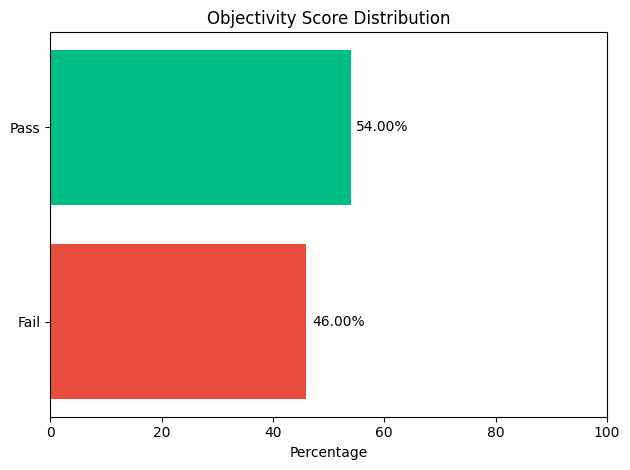

In [25]:
import matplotlib.pyplot as plt

score_pct = df["score"].value_counts(normalize=True).reindex([0, 1]) * 100

for i, value in enumerate(score_pct.values):
    plt.text(value + 1, i, f"{value:.2f}%", va="center")

plt.barh(
    y=["Fail", "Pass"],
    width=score_pct.values,
    color=["#E74C3C", "#00BE83"],
)

plt.xlim(0, 100)
plt.xlabel("Percentage")
plt.title("Objectivity Score Distribution")
plt.tight_layout()
plt.show()

### Summarizing the critiques for insights

In [26]:
from openai import OpenAI

os.environ["OPENAI_API_KEY"] = "<your openAI API key>>"

openai_client = OpenAI()

In [27]:
summarizing_prompt = """
You will be given a list of critiques. Your task is to synthesize them into the distinct failure modes that reflect the core recurring issues.
Include at least one but no more than three failure modes.
You should aim to make them mutually exclusive and cumulatively exhaustive.

Each failure mode should:

- Capture a real, recurring problem (not just one-off concerns)
- Be clearly and concisely worded — avoid vague or generic phrasing
- Represent a meaningful insight, not just surface-level observations

For each failure mode, provide:

- A concise summary of the failure mode (under 200 words)
- A specific example critique that best illustrates the issue
- The index of that critique (each starts with {index}:)

Format your output exactly like this:

**Failure mode**: <concise summary of the failure mode>

**Example critique**: <quoted example that clearly illustrates the failure mode>

**Example critique index**: <index of the example critique>

Additional instructions:

- Avoid rephrasing the same insight in multiple ways — each failure mode should be distinct
- Think critically and look for patterns — what’s the root issue behind multiple critiques?
- Prioritize clarity, depth, and relevance over quantity
"""

### Indentifying failure modes by extracting insights where scores are low

In [28]:
failures = df[df["score"] == 0]

response = openai_client.responses.create(
    model="gpt-4o",
    instructions=summarizing_prompt,
    input = "\n".join(
        f"{i}: {example}"
        for i, example in enumerate(failures["critique"])
    )
)

In [29]:
summary = response.output[0].content[0].text
print(summary)

**Failure mode**: Inaccurate or Misleading Claims

**Example critique**: “The assistant's response contains a statement that is not factually verifiable: ‘The lyrics you've shared come from the song "Take Me to Church" by Hozier.’ This claim is not supported by any evidence and is incorrect, as the lyrics do not match the song "Take Me to Church" by Hozier.”

**Example critique index**: 10

---

**Failure mode**: Fictional or Speculative Content

**Example critique**: “The assistant's response contains several statements that are not factually verifiable, such as the existence of a sinister force driving the inhabitants of Sylt insane, the presence of an ancient artifact linked to a dark entity, and the occurrence of supernatural events. These elements are fictional and not grounded in historical or scientific fact.”

**Example critique index**: 4

---

**Failure mode**: Subjective or Opinion-Based Statements

**Example critique**: “The assistant's response includes several statements 

# 3. Updating the prompt

In the above summary, we see there are 3 failure modes, we update the original prompt based on the insights and create a new prompt.

Here's the new prompt we tried:

  *You are a helpful but unbiased assistant that can answer questions and help with tasks.
   You should never produce any information that is not fully factually verifiable.
   Avoid subjective or opinion-based content.
   You should never present fictional or speculative information.*


For the purposes of the cookbook, we have preloaded GPT responses for this updated prompt. We load that dataset and run evaluations on it again to see if there is improvement.


**If you want to see this live in action,**

Please know that you'll use some of your OpenAI credits.
You can also generate the responses from GPT with the new prompt and run the evaluations to see the updates yourself.

In [30]:
ds = load_dataset("AtlaAI/demo-chat-updated-prompt", split="train")

README.md:   0%|          | 0.00/607 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/45.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50 [00:00<?, ? examples/s]

In [31]:
df = ds.to_pandas()
df.head(5)

,user_input,model_output
0,what are african governments doing to improve ...,African governments are undertaking several me...
1,Please provide us with a list of the best cons...,Sure! Here are some conservation-related start...
2,Explain sarcoidosis to me like I’m a five year...,Sarcoidosis is like when your body's tiny sold...
3,Correct the transcription of an excerpt contai...,"Here's the corrected transcription:\n\n""I got ..."
4,"Hi, I'd like to play ice hockey. Can you expla...",Ice hockey is a fast-paced team sport played o...


In [32]:
print(f"The model output was generated with this updated prompt template:\n`{ds.info.description}`")

The model output was generated with this updated prompt template:
`You are a helpful but unbiased assistant that can answer questions and help with tasks.
You should never produce any information that is not fully factually verifiable.
Avoid subjective or opinion-bsaed content
You should never present fictional or speculative information.`


### Running Selene evaluations on outputs from the updated prompt

In [33]:
eval_tasks = [eval_fn(row, model_output=row["model_output"]) for _, row in df.iterrows()]
eval_results = await asyncio.gather(*eval_tasks)

df["critique"] = [result.critique for result in eval_results]
df["score"] = [int(result.score) for result in eval_results]

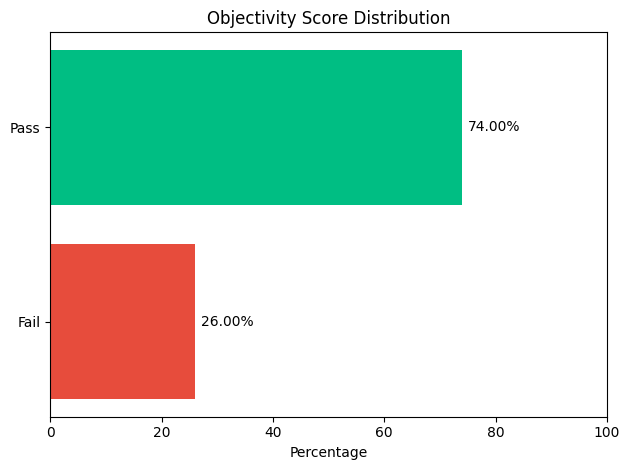

In [34]:
score_pct = df["score"].value_counts(normalize=True).reindex([0, 1]) * 100

for i, value in enumerate(score_pct.values):
    plt.text(value + 1, i, f"{value:.2f}%", va="center")

plt.barh(
    y=["Fail", "Pass"],
    width=score_pct.values,
    color=["#E74C3C", "#00BE83"],
)

plt.xlim(0, 100)
plt.xlabel("Percentage")
plt.title("Objectivity Score Distribution")
plt.tight_layout()
plt.show()

👉 Based on Selene's evaluations, we were able to:

- Quantify exactly how well we our AI assistant was performing in the context of our specific use case
- Get detailed & actionable insight into how we can improve the assistant.
- Implement those insights
- Observe a **20% performance boost** from just one iteration.

# 4. Results & Insights

👀 **Observation**:

We notice that in our initial setup, GPT-4o was prone to producing non-verifiable information.

In the general case, that is not necessarily a bad thing but for our specific use case, this is not acceptable.

💡 **Goal**:

We want our assistant to remain neutral and objective. It should only produce information that the user can verify is accurate, should they wish to do so.

💪 **Action**:

The initial prompt we was clearly not doing enough to get GPT-4o to remain objective.

Therefore, with the help of Selene evaluations, we systematically analyzed exactly where we went wrong and adjusted our prompt accordingly.

👉 **Result**:

We boosted GPT-4o output performance by 20% in just one iteration of improvement.